In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from statistics import mean

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

%matplotlib inline
%precision 4

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shruti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read data
df_movie = pd.read_csv('./imdb_movies.csv')
df_rating = pd.read_csv("./imdb_ratings.csv")

df_all = pd.merge(df_movie, df_rating, on="imdb_title_id", how="inner")

df_all["year"] = df_all["year"].fillna(0)
df_all = df_all[df_all['year']!='TV Movie 2019']
df_all = df_all.astype({'year': 'int32'})

# Using data after year 1980, has less missing data
#df_all = df_all[df_all.year>1980]

# Keep certain features
features = ['imdb_title_id', 'year', 'genre', 'duration', 'country', 'language', 'director', 'writer', 'production_company', 'actors','description', 'votes', 
            'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore', 'reviews_from_users', 'reviews_from_critics','weighted_average_vote',
            'males_0age_votes', 'males_18age_votes', 'males_30age_votes', 'males_45age_votes', 
            'females_0age_votes', 'females_18age_votes', 'females_30age_votes', 'females_45age_votes', 'top1000_voters_votes']
df_all = df_all[features]


print(df_all.shape)
print("Initial dataframe: ")
df_all.head(2)



(85854, 28)
Initial dataframe: 


,imdb_title_id,year,genre,duration,country,language,director,writer,production_company,actors,...,weighted_average_vote,males_0age_votes,males_18age_votes,males_30age_votes,males_45age_votes,females_0age_votes,females_18age_votes,females_30age_votes,females_45age_votes,top1000_voters_votes
0,tt0000009,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",...,5.9,1.0,24.0,36.0,31.0,3.0,14.0,13.0,4.0,34.0
1,tt0000574,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",...,6.1,1.0,102.0,210.0,100.0,NaN,12.0,23.0,14.0,66.0


### Feature processing on number of votes based on age group and gender
#### Finding out if number of votes have a direct correlation with imdb rating based on age group and gender
#### Including number of votes by top 1000 voters as a feature
#### Not sure if these should be used in the analysis but used it anyway
#### Instead of using the average rating by users in the age group which would be directly a dependent variable, using number of votes was a good option

Text(0, 0.5, 'weighted average vote')

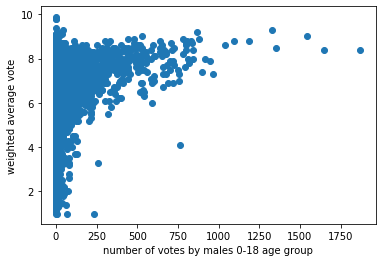

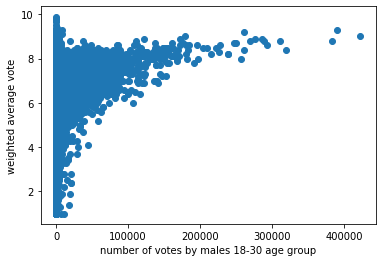

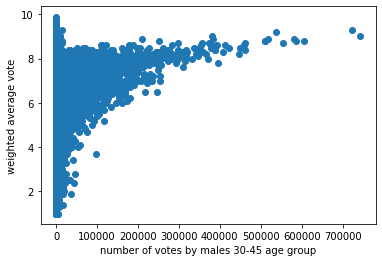

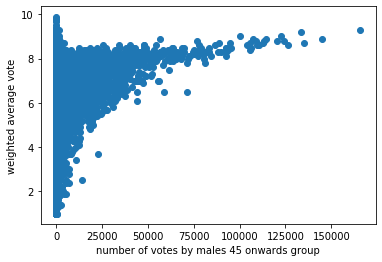

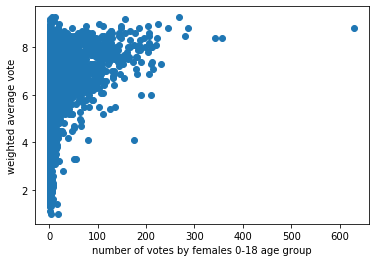

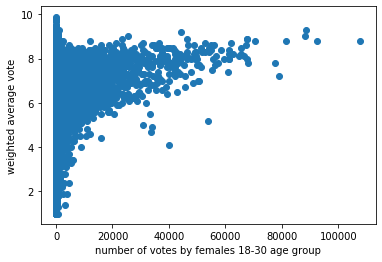

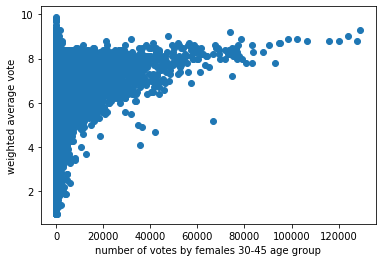

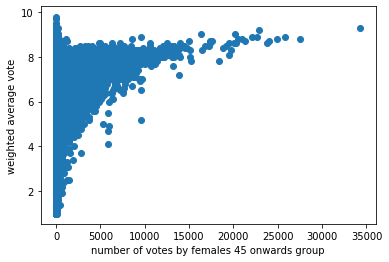

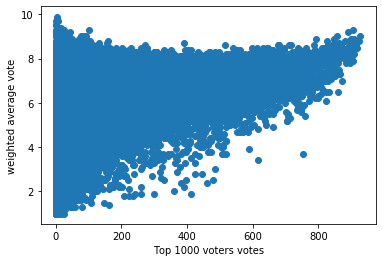

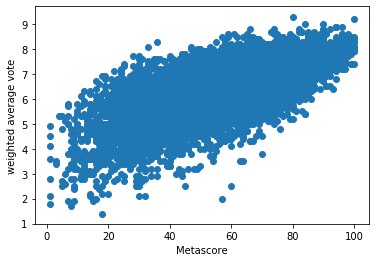

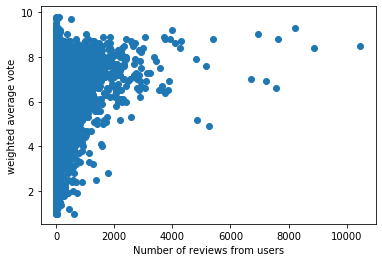

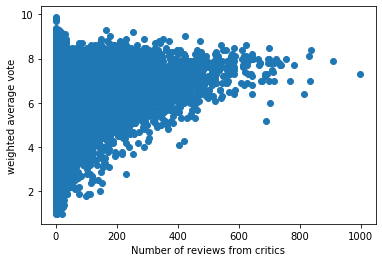

In [3]:
plt.figure()
plt.scatter(df_all.males_0age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by males 0-18 age group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.males_18age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by males 18-30 age group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.males_30age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by males 30-45 age group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.males_45age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by males 45 onwards group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.females_0age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by females 0-18 age group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.females_18age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by females 18-30 age group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.females_30age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by females 30-45 age group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.females_45age_votes, df_all.weighted_average_vote)
plt.xlabel("number of votes by females 45 onwards group")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.top1000_voters_votes, df_all.weighted_average_vote)
plt.xlabel("Top 1000 voters votes")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.metascore, df_all.weighted_average_vote)
plt.xlabel("Metascore")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.reviews_from_users, df_all.weighted_average_vote)
plt.xlabel("Number of reviews from users")
plt.ylabel("weighted average vote")

plt.figure()
plt.scatter(df_all.reviews_from_critics, df_all.weighted_average_vote)
plt.xlabel("Number of reviews from critics")
plt.ylabel("weighted average vote")


### One hot encoding on Genres
#### A total of 25 unique genres(action, thriller, comedy etc.) were found in this whole dataset.
#### Movies which did not have a genre listed had a 0 vector. 
#### Every movie might fall into multiple categories(genres), and hence one hot encoding was the best to express this categorical variable

In [4]:
# Genre one hot encoding
# Get list of genres in dataframe
df_all["genre"] = df_all["genre"].apply(lambda x: str(x).lower())

for item in [","]:
    df_all["genre"] = df_all["genre"].apply(lambda x: x.replace(item, " "))
    
cleaned = df_all.set_index('imdb_title_id')["genre"].str.split(' ', expand=True).stack()
tmp = pd.get_dummies(cleaned, prefix='g').groupby(level=0).sum()
df_all = pd.merge(df_all, tmp, on ='imdb_title_id', how='inner')
df_all.drop(["g_"], axis=1, inplace=True)

features = list(df_all.columns)

print("Genre encoding: ") 
tmp.head(2)

Genre encoding: 


,g_,g_action,g_adult,g_adventure,g_animation,g_biography,g_comedy,g_crime,g_documentary,g_drama,...,g_musical,g_mystery,g_news,g_reality-tv,g_romance,g_sci-fi,g_sport,g_thriller,g_war,g_western
imdb_title_id,,,,,,,,,,,,,,,,,,,,,
tt0000009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
tt0000574,2,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### One hot encoding on year of movie release
#### This categorical feature was one hot encoded based on which decade the movie was released in, instead of using the actual year.
#### The dataset contains movies from 1910 to 2020 and hence 10 groups were formed
#### Every movie would fall in one of the decades, and hence one hot encoding was the best to express this categorical variable

In [5]:
# Year one hot encoding based on decades
df_all['year'] = np.where(df_all['year'] < 1931, 0, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1931,1940), 1, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1941,1950), 2, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1951,1960), 3, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1961,1970), 4, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1971,1980), 5, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1981,1990), 6, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(1991,2000), 7, df_all['year'])
df_all['year'] = np.where(df_all['year'].between(2001,2010), 8, df_all['year'])
df_all['year'] = np.where(df_all['year'] > 2010, 9, df_all['year'])

one_hot_year = pd.get_dummies(df_all['year'],prefix='year')
df_all=df_all.join(one_hot_year)

features = list(df_all.columns)

print("Year encoding: ") 
one_hot_year.head(2)

Year encoding: 


,year_0,year_1,year_2,year_3,year_4,year_5,year_6,year_7,year_8,year_9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0


### Split the data into train(80%) and test(20%) once the one hot encoding is done on categorical variables

In [6]:
# Split train and test data
df, df_test = train_test_split(df_all, test_size=0.2, random_state=1234)


### Feature processing on number of movies released in particular year
#### To find if there is a correlation between number of movies released in a particular year with the imdb rating
#### Turns out the rating was independent of the year when movie was released, I was hoping to have a negative correlation
#### for eg: if a lot of movies are released in one year, it is difficult to have a high imdb rating for one movie, whereas if only 2-3 movies were released in the year, they would have higher rating comparatively because there would be less options to watch
#### Hence, dropped the feature from my analysis

(68683, 63)


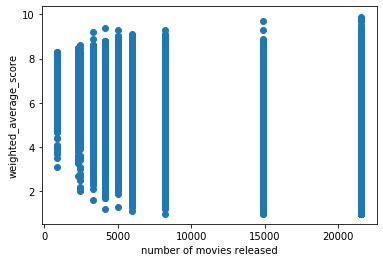

In [7]:
# Get number of movies released that year as a new feature
tot_movies = df.groupby('year').size().reset_index(name='year_based_movie_count')
df1 = pd.merge(df, tot_movies, on='year', how='inner')
df1.drop(['year'], axis=1, inplace=True)
features.remove('year')
features.append('year_based_movie_count')

# df1.head()
print(df1.shape)
plt.scatter(df1["year_based_movie_count"], df1["weighted_average_vote"])
plt.xlabel("number of movies released")
plt.ylabel("weighted_average_score")

################################################################################################################################
#Test dataset
df_test = pd.merge(df_test, tot_movies, on='year', how='inner')
df_test.drop(['year'], axis=1, inplace=True)
################################################################################################################################


### Feature extraction from US income, world income and budget
#### The analysis was to check if income/budget has a positive correlation, as one would expect if the movie earned a lot of money and had a lower budget for the making of the movie, it did a better job and hence higher the rating
#### Because the dataset contains movies all over the world and the budget of the movies would be in different currencies, it is a lot harder to find direct correlation, so converting the budget to usd and then finding the ratio
#### Neither  US income/budget or world income/budget had a correlation as seen from the scatter plot, so dropping these features

(68683, 68)


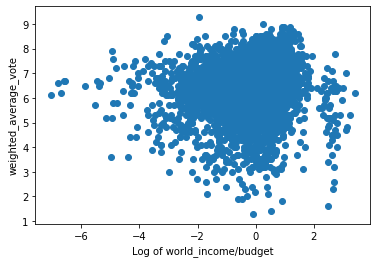

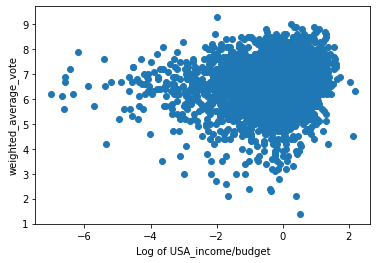

In [8]:
# Get income/budget ratio as a new feature
def get_amount(i):
    if len(str(i).split())>1:
        return float(str(i).split()[1])
    else:
        return float(i)
    
def get_currency(x):
    if len(str(x).split())>1:
        return str(x).split()[0]
    else:
        return "$"
    
def convert_to_USD(args):  
    amt, curr = args 
    rates={'DEM':0.61, '$':1, 'EUR':1.19, 'FRF':0.18, 'ATS':0.08, 'INR':0.013, 'NOK':0.11, 'ESP':0.007, 'CAD':0.79, 'THB':0.03,
           'GBP':1.37, 'JPY':0.009, 'AUD':0.77, 'RUR':0.013, 'ITL':0.0006, 'DKK':0.16, 'BEF':0.029, 'HKD':0.128, 'SEK':0.118, 
           'HUF':0.003, 'BRL':0.178, 'KRW':0.00089, 'SGD':0.748, 'FIM':0.2, 'MXN':0.05, 'CNY':0.15, 'CZK':0.046, 'CHF':1.08,
           'CLP':0.0014, 'PLN':0.26, 'NGN':0.0026, 'NZD':0.716, 'ARS':0.016, 'DOP':0.017, 'ISK':0.0078, 'ILS':0.304, 'ROL':0.24, 
           'PTE':0.0059, 'NLG':0.542, 'BND':0.748, 'EGP':0.063, 'GRD':0.003, 'ZAR':0.07, 'EEK':0.076, 'IRR':0.00002, 'TRL':0.00000012,
           'XAU':1761.29, 'BDT':0.011, 'IEP':1.517, 'MYR':0.242, 'PYG':0.00016, 'SKK':0.039, 'BGL':0.61, 'IDR':0.000068, 'TWD':0.035,
           'MTL':4.35, 'PKR':0.0065, 'SIT':0.0049, 'PHP':0.020, 'HRK':0.158, 'JMD':0.0067, 'COP':0.0002, 'ARS':0.01, 'UAH':0.035, 
           'LVL':1.7, 'VND':0.00004, 'NPR':0.0083, 'CLP':0.0014, 'YUM':0.5, 'LTL':0.34, 'VEB':0.00000000000000425, 'NGN':0.0026, 'ILS':0.304, 
           'TTD':0.147, 'RON':0.242, 'ALL':0.009, 'JOD':1.41, 'GEL':0.291, 'AZM':0.00011, 'LKR':0.0049, 'AED':0.272, 'MNT':0.00035, 'AMD':0.0019}
    return rates[curr] * amt
    
# Convert budget into usd
df_budg = pd.DataFrame()
df_budg["amt"] = df1["budget"].apply(get_amount)
df_budg["curr"] = df1["budget"].apply(get_currency)
df1["budget_usd"] = df_budg.assign(**{'budget_usd': df_budg.apply(convert_to_USD, axis=1)}).budget_usd

# Convert usa gross income into usd
df_usa = pd.DataFrame()
df_usa["amt"] = df1["usa_gross_income"].apply(get_amount)
df_usa["curr"] = df1["usa_gross_income"].apply(get_currency)
df1["usa_income_usd"] = df_usa.assign(**{'usa_income_usd': df_usa.apply(convert_to_USD, axis=1)}).usa_income_usd

# Convert worldwide income into usd
df_world = pd.DataFrame()
df_world["amt"] = df1["worlwide_gross_income"].apply(get_amount)
df_world["curr"] = df1["worlwide_gross_income"].apply(get_currency)
df1["world_income_usd"] = df_world.assign(**{'world_income_usd': df_world.apply(convert_to_USD, axis=1)}).world_income_usd

# Keep only $ currency data points
df2 = df1[features + ["usa_income_usd", "world_income_usd", "budget_usd"]]

df2["usa_income/budget"] = np.log(df2["usa_income_usd"].apply(float)/df2["budget_usd"].apply(float))
df2["world_income/budget"] = np.log(df2["world_income_usd"].apply(float)/df2["budget_usd"].apply(float))

# df2.head()
print(df2.shape)
plt.figure()
plt.scatter(np.log(df2["world_income/budget"]),df2["weighted_average_vote"]) 
plt.xlabel("Log of world_income/budget")
plt.ylabel("weighted_average_vote")

plt.figure()
plt.scatter(np.log(df2["usa_income/budget"]),df2["weighted_average_vote"]) 
plt.xlabel("Log of USA_income/budget")
plt.ylabel("weighted_average_vote")

################################################################################################################################
# Test dataset
df_budg_test = pd.DataFrame()
df_budg_test["amt"] = df_test["budget"].apply(get_amount)
df_budg_test["curr"] = df_test["budget"].apply(get_currency)
df_test["budget_usd"] = df_budg_test.assign(**{'budget_usd': df_budg_test.apply(convert_to_USD, axis=1)}).budget_usd

df_usa_test = pd.DataFrame()
df_usa_test["amt"] = df_test["usa_gross_income"].apply(get_amount)
df_usa_test["curr"] = df_test["usa_gross_income"].apply(get_currency)
df_test["usa_income_usd"] = df_usa_test.assign(**{'usa_income_usd': df_usa_test.apply(convert_to_USD, axis=1)}).usa_income_usd

df_world_test = pd.DataFrame()
df_world_test["amt"] = df_test["worlwide_gross_income"].apply(get_amount)
df_world_test["curr"] = df_test["worlwide_gross_income"].apply(get_currency)
df_test["world_income_usd"] = df_world_test.assign(**{'world_income_usd': df_world_test.apply(convert_to_USD, axis=1)}).world_income_usd

df_test["usa_income/budget"] = np.log(df_test["usa_income_usd"].apply(float)/df_test["budget_usd"].apply(float))
df_test["world_income/budget"] = np.log(df_test["world_income_usd"].apply(float)/df_test["budget_usd"].apply(float))

################################################################################################################################


### Feature: Income
#### As we would expect, higher the income, the movie did well and would have positive correlation with the average rating but the scatter plots say otherwise and hence dropping the features "income"

Text(0, 0.5, 'IMDB rating')

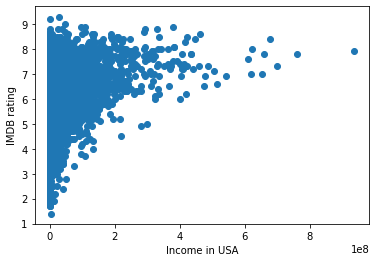

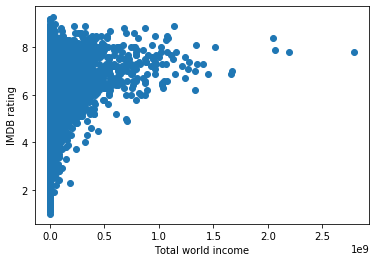

In [9]:
plt.figure()
plt.scatter(df2.usa_income_usd, df2.weighted_average_vote)
plt.xlabel("Income in USA")
plt.ylabel("IMDB rating")

plt.figure()
plt.scatter(df2.world_income_usd, df2.weighted_average_vote)
plt.xlabel("Total world income")
plt.ylabel("IMDB rating")


### Feature extraction for actors in the movie
#### Find the average rating of the actor based on how many movies they have acted in and what their imdb ratings were in the training set and store in a dictionary.
#### For both training and testing set, find all the actor ratings and then take an average of those for each movie
#### for eg: in movie A, Actor 1, 2 and 3 starred, average(rating(actor 1) + rating(actor 2) + rating(actor 3)) would be the new feature "actor based rating" for movie A.

(68683, 68)


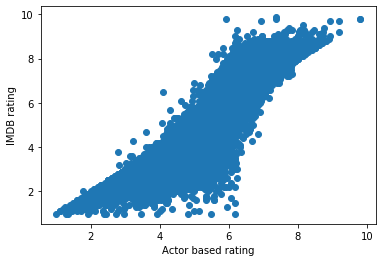

In [10]:
# Actors rating and number of movies they starred in
tmp_act_df = df2.copy()
tmp_act_df['actors'] = df2['actors'].fillna("None")
tmp_act_df['actors'] = tmp_act_df['actors'].str.split(', ')

# get avg_vote for each actor in each movie
flat = [[x, tmp_act_df.loc[i, "weighted_average_vote"]] for i, y in tmp_act_df['actors'].iteritems() for x in y]
rating_df = pd.DataFrame(flat, columns=["actor", "rating"])

# get mean rating of an actor based on the number of movies they have done
actor_df = pd.DataFrame(rating_df.groupby('actor').size(), columns=["movies"])
actor_df['rating'] = rating_df.groupby('actor').mean()
act_d = actor_df.to_dict()

# avg rating based on actors
ls = []
for i in range(0, tmp_act_df.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_act_df['actors'][i])):
        ls_.append(act_d['rating'][tmp_act_df['actors'][i][j]])
    ls.append(mean(ls_))
df2["actors_based_rating"] = ls
df2.drop(['actors'], axis=1, inplace=True)
features= df2.columns

# df2.head()
print(df2.shape)
plt.scatter(df2["actors_based_rating"], df2["weighted_average_vote"])
plt.xlabel("Actor based rating")
plt.ylabel("IMDB rating")

################################################################################################################################
# Test dataset 
tmp_df_test = df_test.copy()
tmp_df_test['actors'] = df_test['actors'].fillna("None")
tmp_df_test['actors'] = tmp_df_test['actors'].str.split(', ')

ls = []
for i in range(0, tmp_df_test.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_df_test['actors'][i])):
        if tmp_df_test['actors'][i][j] not in act_d['rating']:
            ls_.append(0)
        else:
            ls_.append(act_d['rating'][tmp_df_test['actors'][i][j]])
    ls.append(mean(ls_))
df_test["actors_based_rating"] = ls
df_test.drop(['actors'], axis=1, inplace=True)
################################################################################################################################


### Feature processing for directors of the movie
#### Find the average rating of the director based on how many movies they have directed and what their imdb ratings were in the training set and store in a dictionary.
#### For both training and testing set, find all the director ratings and then take an average of those for each movie
#### for eg: Movie B was directed by director x and y, then average(rating(director x), rating(director y)) would be the new feature "director based rating" for movie B.

(68683, 68)


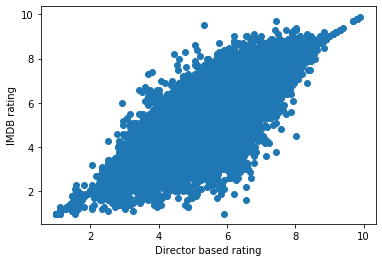

In [11]:
# Directors rating and number of movies they directed
tmp_dir_df = df2.copy()
tmp_dir_df['director'] = df2['director'].fillna("None")
tmp_dir_df['director'] = tmp_dir_df['director'].str.split(', ')

# get avg_vote for each director in each mive
flat = [[x, tmp_dir_df.loc[i, "weighted_average_vote"]] for i, y in tmp_dir_df['director'].iteritems() for x in y]
rating_df = pd.DataFrame(flat, columns=["director", "rating"])

# get mean rating of a director based on the number of movies they have directed
director_df = pd.DataFrame(rating_df.groupby('director').size(), columns=["movies"])
director_df['rating'] = rating_df.groupby('director').mean()
dir_d = director_df.to_dict()

# avg rating based on directors
ls = []
for i in range(0, tmp_dir_df.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_dir_df['director'][i])):
        ls_.append(dir_d['rating'][tmp_dir_df['director'][i][j]])
    ls.append(mean(ls_))
df2["director_based_rating"] = ls
df2.drop(['director'], axis=1, inplace=True)
features= df2.columns

# df2.head()
print(df2.shape)
plt.scatter(df2["director_based_rating"], df2["weighted_average_vote"])
plt.xlabel("Director based rating")
plt.ylabel("IMDB rating")

################################################################################################################################
# Test dataset 
tmp_df_test = df_test.copy()
tmp_df_test['director'] = df_test['director'].fillna("None")
tmp_df_test['director'] = tmp_df_test['director'].str.split(', ')

ls = []
for i in range(0, tmp_df_test.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_df_test['director'][i])):
        if tmp_df_test['director'][i][j] not in dir_d['rating']:
            ls_.append(0)
        else:
            ls_.append(dir_d['rating'][tmp_df_test['director'][i][j]])
    ls.append(mean(ls_))
df_test["director_based_rating"] = ls
df_test.drop(['director'], axis=1, inplace=True)
################################################################################################################################


### Feature processing for writer of the movie
#### Find the average rating of the writer based on how many movies they have written and what their imdb ratings were in the training set and store in a dictionary.
#### For both training and testing set, find all the writer ratings and then take an average of those for each movie
#### for eg: Movie B was written by writer 1, 2 and 3, then average(rating(writer 1) + rating(writer 2) + rating(writer 3)) would be the new feature "writer based rating" for movie B.

(68683, 68)


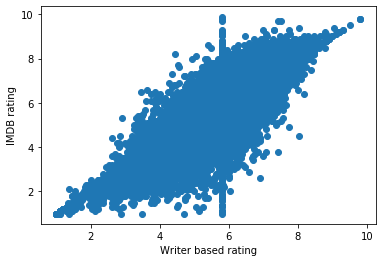

In [12]:
# Writers rating and number of movies they wrote
tmp_wr_df = df2.copy()
tmp_wr_df['writer'] = df2['writer'].fillna("None")
tmp_wr_df['writer'] = tmp_wr_df['writer'].str.split(', ')

# get avg_vote for each writer in each movie
flat = [[x, tmp_wr_df.loc[i, "weighted_average_vote"]] for i, y in tmp_wr_df['writer'].iteritems() for x in y]
rating_df = pd.DataFrame(flat, columns=["writer", "rating"])

# get mean rating of a writer based on the number of movies they have written
writer_df = pd.DataFrame(rating_df.groupby('writer').size(), columns=["movies"])
writer_df['rating'] = rating_df.groupby('writer').mean()
wr_d = writer_df.to_dict()

# avg rating based on writers
ls = []
for i in range(0, tmp_wr_df.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_wr_df['writer'][i])):
        ls_.append(wr_d['rating'][tmp_wr_df['writer'][i][j]])
    ls.append(mean(ls_))
df2["writer_based_rating"] = ls
df2.drop(['writer'], axis=1, inplace=True)
features= df2.columns

# df2.head()
print(df2.shape)
plt.scatter(df2["writer_based_rating"], df2["weighted_average_vote"])
plt.xlabel("Writer based rating")
plt.ylabel("IMDB rating")

################################################################################################################################
# Test dataset 
tmp_df_test = df_test.copy()
tmp_df_test['writer'] = df_test['writer'].fillna("None")
tmp_df_test['writer'] = tmp_df_test['writer'].str.split(', ')

ls = []
for i in range(0, tmp_df_test.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_df_test['writer'][i])):
        if tmp_df_test['writer'][i][j] not in wr_d['rating']:
            ls_.append(0)
        else:
            ls_.append(wr_d['rating'][tmp_df_test['writer'][i][j]])
    ls.append(mean(ls_))
df_test["writer_based_rating"] = ls
df_test.drop(['writer'], axis=1, inplace=True)
################################################################################################################################


### Feature extraction from "language"
#### Group by languages and sort them based on how many movies are there in a particular combination of languages
#### Take the average of imdb ratings for each combination of languages in the training set
#### Find the standard deviation of imdb ratings for each combination of languages in the training set
#### Use these as the new features : language based ratings

Group by languages:  language
English                                         True
French                                          True
Spanish                                         True
Japanese                                        True
Italian                                         True
                                                ... 
Hindi, Marathi, Gujarati                        True
Hindi, Marathi, English, Tamil                  True
Hindi, Marathi, Bengali, English, Portuguese    True
Hindi, Malayalam, Tamil                         True
Aboriginal                                      True
Length: 3736, dtype: bool


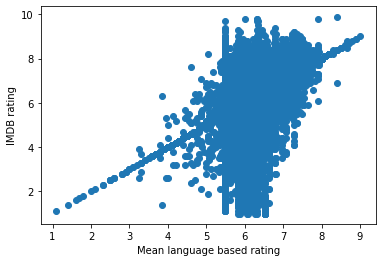

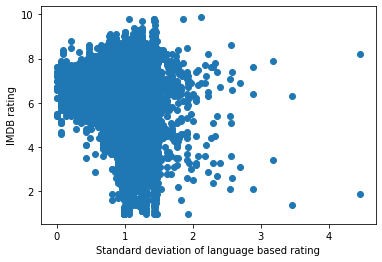

In [13]:
# Votes based on language
include_l = df2.groupby('language').size().sort_values(ascending=False) >= 1
lang_df = df2.groupby('language').mean().loc[include_l].sort_values("weighted_average_vote", ascending=False)
lang_df.rename({'weighted_average_vote': 'language_based_rating_mean'}, axis=1, inplace=True)
df3 = pd.merge(df2, lang_df["language_based_rating_mean"], on="language", how="inner")
print("Group by languages: ", include_l)

lang_df = df3.groupby('language').std().loc[include_l].sort_values("weighted_average_vote", ascending=False)
lang_df.rename({'weighted_average_vote': 'language_based_rating_std'}, axis=1, inplace=True)
df3 = pd.merge(df3, lang_df["language_based_rating_std"], on="language", how="inner")

plt.figure()
plt.scatter(df3["language_based_rating_mean"], df3["weighted_average_vote"])
plt.xlabel("Mean language based rating")
plt.ylabel("IMDB rating")

plt.figure()
plt.scatter(df3["language_based_rating_std"], df3["weighted_average_vote"])
plt.xlabel("Standard deviation of language based rating")
plt.ylabel("IMDB rating")

df3.drop(["language", "language_based_rating_std"], axis=1, inplace=True)

################################################################################################################################
# Test dataset
df_test = pd.merge(df_test, lang_df["language_based_rating_mean"], on="language", how="inner")
df_test.drop(["language"], axis=1, inplace=True)
################################################################################################################################


### Feature extraction from "country"
#### Group by countries where the movie was released and sort them based on how many movies are there in a particular combination of countries
#### Take the average of imdb ratings for each combination of countries in the training set
#### Find the standard deviation of imdb ratings for each country combination in the training set
#### Use these as the new features : country based ratings

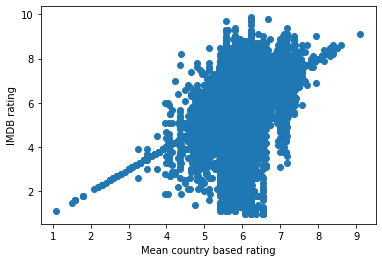

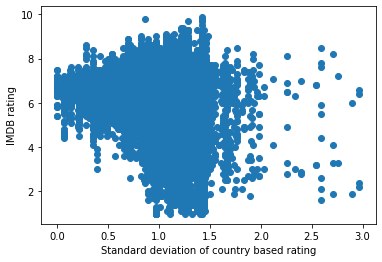

In [14]:
# Votes based on country
include_c = df3.groupby('country').size().sort_values(ascending=False) >= 1
country_df = df3.groupby('country').mean().loc[include_c].sort_values("weighted_average_vote", ascending=False)
country_df.rename({'weighted_average_vote': 'country_based_rating_mean'}, axis=1, inplace=True)
df4 = pd.merge(df3, country_df["country_based_rating_mean"], on="country", how="inner")

country_df = df4.groupby('country').std().loc[include_c].sort_values("weighted_average_vote", ascending=False)
country_df.rename({'weighted_average_vote': 'country_based_rating_std'}, axis=1, inplace=True)
df4 = pd.merge(df4, country_df["country_based_rating_std"], on="country", how="inner")

plt.figure()
plt.scatter(df4["country_based_rating_mean"], df4["weighted_average_vote"])
plt.xlabel("Mean country based rating")
plt.ylabel("IMDB rating")

plt.figure()
plt.scatter(df4["country_based_rating_std"], df4["weighted_average_vote"])
plt.xlabel("Standard deviation of country based rating")
plt.ylabel("IMDB rating")

df4.drop(["country", "country_based_rating_std"], axis=1, inplace=True)

################################################################################################################################
# Test dataset
df_test = pd.merge(df_test, country_df["country_based_rating_mean"], on="country", how="inner")
df_test.drop(["country"], axis=1, inplace=True)
################################################################################################################################



### Feature processing on duration of the movie
#### Find correlation of duration of the movie in minutes vs. the weighted average rating, we would expect very short films and very very long duration films to have less imdb rating but turns out, there is no relation
#### for eg: 800 minute long movie had a rating of ~8, seen from the scatter plot
#### no correlation was found and hence dropped the feature

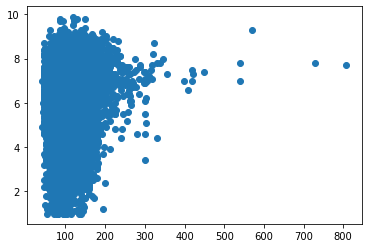

In [15]:
# Correlation between duration of the movie and the avg_vote
plt.scatter(df4["duration"], df4["weighted_average_vote"])

# No correlation hence dropping the feature
df5 = df4.drop(['duration'], axis=1)
features = df5.columns

df5.head()
# df5.shape

################################################################################################################################
# Test dataset
df_test.drop(['duration'], axis=1, inplace=True)
################################################################################################################################


### Feature processing for production company
#### Find the average rating of the production company based on how many movies they have produced till date and their imdb ratings in the training set and store in a dictionary.
#### For both training and testing set, find all the production company ratings and then take an average of those for each movie
#### for eg: Movie B was produced by company 1, then rating(producer 1) would be the new feature "producer based rating" for movie B.
#### if multiple producers are involved, an average rating of them would be the new "producer based rating" for the movie.

(67987, 67)


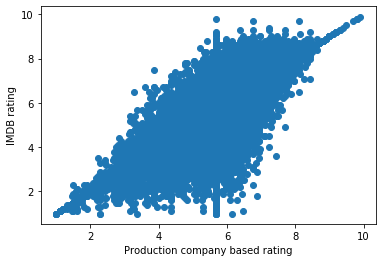

In [16]:
# Production company based rating
tmp_prod_df = df5.copy()
tmp_prod_df['production_company'] = df5['production_company'].fillna("None")
tmp_prod_df['production_company'] = tmp_prod_df['production_company'].str.split(', ')

# get avg_vote for each genre
flat = [[x, tmp_prod_df.loc[i, "weighted_average_vote"]] for i, y in tmp_prod_df['production_company'].iteritems() for x in y]
rating_df = pd.DataFrame(flat, columns=["production_company", "rating"])

prod_df = pd.DataFrame(rating_df.groupby('production_company').size(), columns=["movies"])
prod_df['rating'] = rating_df.groupby('production_company').mean()
prod_d = prod_df.to_dict()

# avg rating based on genre
ls = []
for i in range(0, tmp_prod_df.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_prod_df['production_company'][i])):
        ls_.append(prod_d['rating'][tmp_prod_df['production_company'][i][j]])
    ls.append(mean(ls_))
df5["prod_based_rating"] = ls
df5.drop(['production_company'], axis=1, inplace=True)
features= df5.columns

# df5.head()
print(df5.shape)
plt.scatter(df5["prod_based_rating"], df5["weighted_average_vote"])
plt.xlabel("Production company based rating")
plt.ylabel("IMDB rating")

################################################################################################################################
# Test dataset 
tmp_df_test = df_test.copy()
tmp_df_test['production_company'] = df_test['production_company'].fillna("None")
tmp_df_test['production_company'] = tmp_df_test['production_company'].str.split(', ')

ls = []
for i in range(0, tmp_df_test.shape[0]):
    ls_ = []
    for j in range(0, len(tmp_df_test['production_company'][i])):
        if tmp_df_test['production_company'][i][j] not in prod_d['rating']:
            ls_.append(0)
        else:
            ls_.append(prod_d['rating'][tmp_df_test['production_company'][i][j]])
    ls.append(mean(ls_))
df_test["prod_based_rating"] = ls
df_test.drop(['production_company'], axis=1, inplace=True)
################################################################################################################################


In [17]:
df5.dropna(inplace=True)
df_test.dropna(inplace=True)

### Vectorize the description using NLP
#### remove the stopwords, punctuation marks and get the plot word set
#### Apply tfidf vectorizer from nltk and PCA to get the top 500 features from the "description" of the movie
#### If more data was used, and had more computational resources, this would have been a good feature which would have directly correlated with the imdb rating

In [18]:
# Vectorize description
df5["description"] = df5["description"].apply(lambda x: str(x).lower())
df_test["description"] = df_test["description"].apply(lambda x: str(x).lower())
stopWords = set(stopwords.words('english')) 

for item in [".", ",", "!", ")", "(", "&", "*", "_", "-", "+", "=", "\'", "\"", "|", ":", ";", "/"]:
    df5["description"] = df5["description"].apply(lambda x: x.replace(item, " "))
    df_test["description"] = df_test["description"].apply(lambda x: x.replace(item, " "))

for word in stopWords:
    df5["description"] = df5["description"].apply(lambda x: x.replace(" "+word+" ", " "))
    df_test["description"] = df_test["description"].apply(lambda x: x.replace(" "+word+" ", " "))
    
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(df5["description"])
tfidf_test = vectorizer.transform(df_test["description"])

pca = PCA(n_components=500)
lower_dim_tfidf_train = pca.fit_transform(tfidf_train.todense())
lower_dim_tfidf_test = pca.transform(tfidf_test.todense())

df6 = pd.concat([df5, pd.DataFrame(lower_dim_tfidf_train)], axis=1)
df_test1 = pd.concat([df_test, pd.DataFrame(lower_dim_tfidf_test)], axis=1)


### Drop data points with missing values, assuming imputation would add bias to the data
#### Use Lasso due to feature selection and shrinkage whereas ridge regression just allows shrinkage.
#### Use cross validation model with 5-folds(to avoid overfitting)
#### Best ways to validate the model is Calculating the mean absolute error(MAE) and root mean squared error between the predicted ratings and the ground truth, lesser the MAE, closer ris the prediction to the actual IMDB rating

Mean squared error:  0.7491827336008329
Mean absolute error:  0.6612776698397775


Text(0, 0.5, 'Count')

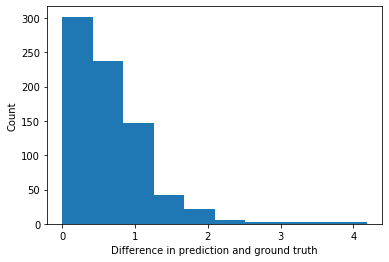

In [28]:
# Drop NA's
df6.dropna(inplace=True)
df_test1.dropna(inplace=True)

# Split features and labels
X_train = df5.drop(['weighted_average_vote', 'imdb_title_id', 'description', 'year_based_movie_count', 'genre', 'votes', 'usa_income/budget', 'world_income/budget',
                   'budget', 'usa_gross_income', 'worlwide_gross_income', 'usa_income_usd', 'world_income_usd', 'budget_usd'], axis=1)
y_train = df5['weighted_average_vote']

X_test = df_test.drop(['weighted_average_vote', 'imdb_title_id', 'description', 'year_based_movie_count', 'genre', 'votes', 'usa_income/budget', 'world_income/budget',
                      'budget', 'usa_gross_income', 'worlwide_gross_income', 'usa_income_usd', 'world_income_usd', 'budget_usd'], axis=1)
y_test = df_test['weighted_average_vote']

clf = LassoCV(cv=5, random_state=0)

# Training
clf.fit(X_train, y_train)

# Save the model
filename = "./results/model_lasso.sav"
pickle.dump(clf, open(filename, 'wb'))

# Prediction on test set
y_pred_test = clf.predict(X_test)

# Performance: Root Mean Squared Loss
mse = mean_squared_error(y_test, y_pred_test)
print("Mean squared error: ", mse)

mae = mean_absolute_error(y_test, y_pred_test)
print("Mean absolute error: ", mae)

df_prediction = pd.DataFrame()
df_prediction["weighted_average_vote"] = y_pred_test
df_prediction.to_csv("./results/prediction_lasso.csv", index=False)

plt.hist(np.abs(y_pred_test - y_test))
plt.xlabel("Difference in prediction and ground truth")
plt.ylabel("Count")


Mean squared error:  5.029143771170151
Mean absolute error:  1.9018208430545023


Text(0, 0.5, 'Count')

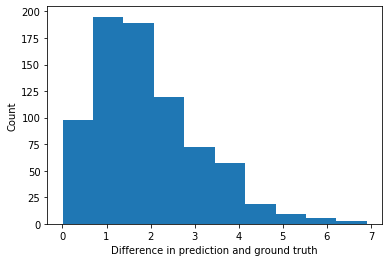

In [29]:
clf = RidgeCV()

# Training
clf.fit(X_train, y_train)

# Save the model
filename = "./results/model_ridge.sav"
pickle.dump(clf, open(filename, 'wb'))

# Prediction on test set
y_pred_test = clf.predict(X_test)

# Performance: Root Mean Squared Loss
mse = mean_squared_error(y_test, y_pred_test)
print("Mean squared error: ", mse)

mae = mean_absolute_error(y_test, y_pred_test)
print("Mean absolute error: ", mae)

df_prediction = pd.DataFrame()
df_prediction["weighted_average_vote"] = y_pred_test
df_prediction.to_csv("./results/prediction_ridge.csv", index=False)

plt.hist(np.abs(y_pred_test - y_test))
plt.xlabel("Difference in prediction and ground truth")
plt.ylabel("Count")


Mean squared error:  5.7011741945169705
Mean absolute error:  1.9115052219321151


Text(0, 0.5, 'Count')

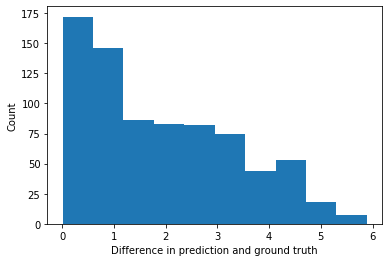

In [30]:
clf = RandomForestRegressor()

# Training
clf.fit(X_train, y_train)

# Save the model
filename = "./results/model_rf.sav"
pickle.dump(clf, open(filename, 'wb'))

# Prediction on test set
y_pred_test = clf.predict(X_test)

# Performance: Root Mean Squared Loss
mse = mean_squared_error(y_test, y_pred_test)
print("Mean squared error: ", mse)

mae = mean_absolute_error(y_test, y_pred_test)
print("Mean absolute error: ", mae)

df_prediction = pd.DataFrame()
df_prediction["weighted_average_vote"] = y_pred_test
df_prediction.to_csv("./results/prediction_rf.csv", index=False)

plt.hist(np.abs(y_pred_test - y_test))
plt.xlabel("Difference in prediction and ground truth")
plt.ylabel("Count")


#### Compared with a few machine learning models(Lasso, Ridge, Random Forest), found Lasso to be the best with MAE of 0.66 and RMSE of 0.74